In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
column_names = ['label']
df = pd.read_csv('spam.csv', delimiter=',', encoding='latin-1')
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2618,ham,Hey pple...$700 or $900 for 5 nights...Excelle...,NaN,NaN,NaN
787,spam,Ever thought about living a good life with a p...,NaN,NaN,NaN
4512,spam,Money i have won wining number 946 wot do i do...,NaN,NaN,NaN
5110,spam,You have 1 new message. Please call 08715205273,NaN,NaN,NaN
3712,ham,If i not meeting Ì_ all rite then i'll go home...,NaN,NaN,NaN


In [3]:
df.info()
#need to clean data up was read in very messy have 5 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
#going to drop the unnamed columns as they are irrelelvant and are mostly null
#ex unnamed 4 only has 6 non null objects out of 5572 rows
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

#rename v1 and v2 columns, v1 = ham/spam, v2 = message
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
#check for missing and duplicate values
df.duplicated().sum()

np.int64(403)

In [6]:
#have 403 duplicates can drop
df.drop_duplicates(inplace=True)
#we keep first one
df.shape

(5169, 2)

In [7]:
#check how many rows have missing values
df.isnull().sum()
#no missing value rows so we dont have to do it

label      0
message    0
dtype: int64

In [8]:
#eda to summarize main characteristics and find outliers
print("label counts, ham vs spam")
print(df['label'].value_counts())

print("label %")
print(df['label'].value_counts(normalize=True) * 100)

label counts, ham vs spam
label
ham     4516
spam     653
Name: count, dtype: int64
label %
label
ham     87.366996
spam    12.633004
Name: proportion, dtype: float64


In [9]:
#dataset is highly imbalanced will have to oversample and undersample likely to avoid bais
#next get info on messages and their length

#creates new column
df['message_len'] = df['message'].apply(len)
print(df['message_len'].describe())
#lots of varaiance however mean len is 78 with max being 910

count    5169.000000
mean       78.977945
std        58.236293
min         2.000000
25%        36.000000
50%        60.000000
75%       117.000000
max       910.000000
Name: message_len, dtype: float64


In [10]:
#try to differentiate lengths for ham vs spam
# print(df[df['label'] == 'ham']['message_len'].describe())
# print(df[df['label'] == 'spam']['message_len'].describe())

#word count probably better indicator than characters
#add  a new row with number of words
df['num_words'] = df['message'].apply(lambda x:len(x.split()))
print(df[df['label'] == 'ham']['num_words'].describe())
print(df[df['label'] == 'spam']['num_words'].describe())
#spam tends to be a lot longer

#make another row for special character (ex congratulations!! 100% free)
#or just other special characters to try and avoid detection
df['numspecial_chars'] = df['message'].apply(lambda x: len([char for char in x if char in '!$%?_@*()']))


count    4516.000000
mean       14.134632
std        11.116240
min         1.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       171.000000
Name: num_words, dtype: float64
count    653.000000
mean      23.681470
std        5.967672
min        2.000000
25%       22.000000
50%       25.000000
75%       28.000000
max       35.000000
Name: num_words, dtype: float64


<Axes: xlabel='num_words', ylabel='Count'>

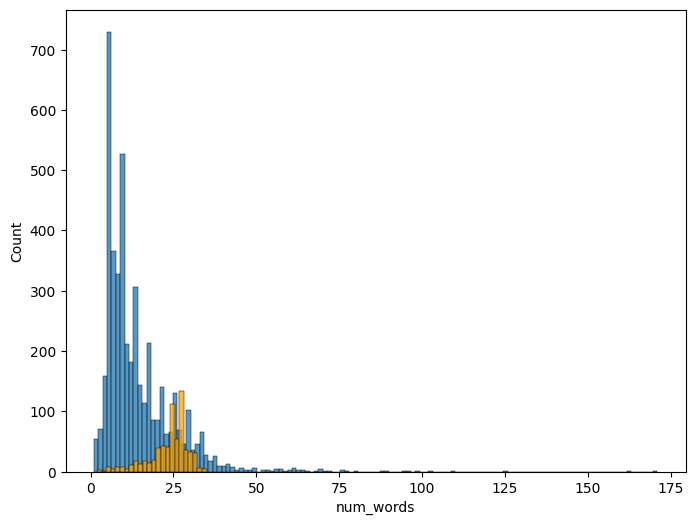

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(df[df['label'] == 'ham']['num_words'])
sns.histplot(df[df['label'] == 'spam']['num_words'], color='orange')
#graph isn't corected for data will do later

In [12]:
#preprocess data, get it ready for training
#I'm going to focus on wording to see which words are associated heavier with spam
#will tokenize messages to get words
#import the stopwords and stemmer from nltk so we can generalize data better

ps = PorterStemmer()
stopWordss = stopwords.words('english')

def preprocess_text(text):
    text = text.lower() #keep everything same case for ascii
    wordToken = nltk.word_tokenize(text) #split text to words
    processedList = []
    for word in wordToken:
        if word.isalnum():#if word is alpha numeric only
            if word not in stopWordss:
                processedList.append(ps.stem(word))
    return " ".join(processedList) #joins all processed words into single string
    

In [13]:
df['processedMessage'] = df['message'].apply(preprocess_text)

df['processedMessage'][41]
#have tokenized and cleaned up words

'forget tell want need crave love sweet arabian steed mmmmmm yummi'

In [14]:
spamWordList = []
hamWordList = []

for m in df[df['label'] == 'spam']['processedMessage'].tolist():
    for word in m.split():
        spamWordList.append(word)

for m in df[df['label'] == 'ham']['processedMessage'].tolist():
    for word in m.split():
        hamWordList.append(word)



In [15]:
#will get the top 20 words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['processedMessage']
Y = df['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=19, stratify=Y)

cv = TfidfVectorizer(max_features=3000) #we limit the amount of features to handle for memory and overfitting
X_train_tfidf = cv.fit_transform(X_train)
X_test_tfidf = cv.transform(X_test)

#gaussian matrix requires array to store all values explicitly
X_train_arr = X_train_tfidf.toarray()
X_test_arr = X_test_tfidf.toarray()

#can implement with class priors

spam_prior = y_train.mean()
ham_prior = 1 - spam_prior

priors = [0.5, 0.5] # set equal for ham and spam

gaussianMod = GaussianNB(priors=priors)
gaussianMod.fit(X_train_arr, y_train)

y_pred = gaussianMod.predict(X_test_arr)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print("Confusion matrix: ", confusion_matrix(y_test, y_pred))

Accuracy:  0.8423597678916828
Classification report:                precision    recall  f1-score   support

         ham       0.97      0.84      0.90       903
        spam       0.44      0.83      0.57       131

    accuracy                           0.84      1034
   macro avg       0.70      0.84      0.74      1034
weighted avg       0.90      0.84      0.86      1034

Confusion matrix:  [[762 141]
 [ 22 109]]


In [17]:
#build model, going to start with naive bayes as that goes off word count
#naive bayes input has two words (dear friend) probably that it is in category a is
#P(a) * P(dear) * P(Friend), issue where a 0 percent chance where word doesn't show up in sample set
#can fix by incrementing count

#include class weights as dataset is skewed
#laplace smoothing helps fix probability 0 returns



X = df['processedMessage']
Y = df['label'].map({'ham': 0, 'spam': 1}) #want to predict Y scikit also wants nubmer

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=19, stratify=Y)
#allocate 20% of data to test and 80% to train

cv = CountVectorizer()
#converts each mmessage to numeric vector with vocubalary from trraining data
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)

#fit_prior = true allows for us to adjust for biases based off skewed data
#model wil learn class priors based on the dataset imbalance
# naiveBayesMod = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=[0.5, 0.5]) #add laplace smoothing so no 0 prob
naiveBayesMod = MultinomialNB(alpha=1.0, fit_prior=True)
naiveBayesMod.fit(X_train_vec, y_train)

y_pred = naiveBayesMod.predict(X_test_vec)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred, target_names=['ham', 'spam']))
print("Confusion matrix: ", confusion_matrix(y_test, y_pred))

Accuracy:  0.9825918762088974
Classification report:                precision    recall  f1-score   support

         ham       0.98      1.00      0.99       903
        spam       0.97      0.89      0.93       131

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

Confusion matrix:  [[899   4]
 [ 14 117]]


In [18]:
#prepare for web deployment
import pickle

pickle.dump(cv, open('naiveBayes.pkl', 'wb'))
pickle.dump(naiveBayesMod, open('spamModel.pkl', 'wb'))